<h1>From Image to GPS Art</h1>

This jupyter notebook demonstrates how to take an image and recreate it as a GPS route for use in navigating GPS art. 

I feel I ought to start out by stating that this is by no means a tutorial on the best practices of coding and my knowledge of all the components used vary - I am relatively new to several of the elements used here. Instead, treat this notebook as the (slightly) tidied up scribblings and workings as I set about the problem.

Not all parts are fully automated yet, but the intention is to revist this problem in my free time to better scale, translate and rotate the image to best suit the location.

<h2>Setup and prerequisites</h2>

From here on in, I am assuming you are competent enough in the python language and understand how to get all the required libaries etc. to make this notebook function.

However, if you don't think you are - you can still play with the code: just click in the boxes with the code and push `shift` + `enter` and the code in that box should run (you will need to do it in the sequence it is written).

Firstly, the image that you wish to recreate needs to be selected. Here, I have chosen the GRGR 2020 logo as shown in the figure below (this whole notebook came about because of The Ginger Runner's Global Run (GRGR - https://www.rungrgr.com)). 

<img src="./img/GRGR2020_ColorLogo.png" alt="GRGR Logo" width="200"/>

If you want some back story here it is (if not skip to the next paragraph!): I ran the GRGR '19 logo as my  <a href="https://www.strava.com/activities/2786773404">attempt</a> for the GPS art award (which was a 2 hour event). To create the logo, I hand drew the logo in Suunto's Movescount map - it was a one-shot draw and then serveral iterations as I compared the screenshots to a semitransparent copy of the logo and the tweaked accordingly. It was labourious. When GRGR2020 was announced as a week long event full of surprise challenges I knew I needed to have another go at GPS art and I needed a better way to create it! And that, my friends, is how this notebook came in to existance. Right, back to the workings... 

It is important to note that the image should be fairly easy to recreate as a continuous-line drawing and therefore will be easy to transfer to a GPS route without loosing the image's detail. If you wish to recreate a more complex image (for example, a cartoon or a photo) then you will need to dig deep into your creative pocket to work out how much detail you want to recreate as lines.

To make the continous-line image, the original image was opened in Inkscape (an open-source graphics editing tool https://inkscape.org/) and a route was traced over the top of the image (using the 'Draw Bezier curves and straight lines' tool) so that all the lines could be linked continuously - note: only use straight lines (as this is needed for the next step. In this image's case it required several repeated sections, which ideally need to be minimised for ease of running (and also the distance will be minimised!). The resulting SVG file can be seen below.

<img src="./img/grgr2020.svg" alt="GRGR route" width="200"/>

From here, the SVG was saved as a DXF (a file format associated with drawing and CAD) using Inkscape. Some key points should be observed here:
 <ol>
  <li>The width of the line drawing should be set to a sensible value for scaling (I resized the line drawings to be 100 mm wide throughout all my designs)</li>
  <li>Remove all layers so that the SVG consists of just a path (this should guarantee the LWPolyline will be in Layer 0). This can be done by firstly cutting the line-drawing and deleting everything else in the document, then in the 'Objects' tab removing any layers (highlight it and click the '-' sign at the bottom) and then paste and centre your drawing.</li>
    <li>The document should be resized to the path object (this allow the centre of the drawing to found in the code).</li>
</ol>

Once this is done and you have your saved DXF file you are good to start working through this notebook.


# From image to GPS route

## The Code

### Import the DXF

From here on in I will walk you through my code and attempt to give an explaination of what is happening. We start by importing all the required python libaries for this task (some might be obselete!):

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import dxfgrabber
import folium
import cmath as cm
from shapely.geometry import LineString
from geopandas import GeoDataFrame
from operator import itemgetter
from pyproj import CRS

Next up is reading in the DXF file (either the example I have provided or one you have just created) and adding some variables we are going to call upon later.

Now, this single code box is the section you want to play with if you want to change the size, location or even route. Everything else from here just processes it (and displays it as we go).

In [2]:
########### FOR YOU TO PLAY WITH ################

# Read the DXF file from it's location in the repository:
grgr_dxf = dxfgrabber.readfile("./img/grgr2020.dxf") # another example provided is "./img/donkey.dxf"

# set a target output file and filename:
grgr_gpx = "./out/grgr2020.gpx" # if you change the input file, don't forget to change the output name

# set the width of the GPS drawing (scale * width):
scale = 10 # use this value to change the size of the route
# desired lat long centre point:
centre_latlon = [50.9615, -1.6034] # be sure to change this to the centre of your local canvas

Then we manipulate the data to collect the vertices of the route:

In [3]:
# get vertices from dxf file:
layer = [entity for entity in grgr_dxf.entities if entity.layer =='0']
grgr_vertices = [entity.points for entity in layer if entity.dxftype == 'LWPOLYLINE']

# get x and y offset values to find the centre of the drawing:
offset_x = max(grgr_vertices[0],key=itemgetter(0))[0] / 2.0
offset_y = max(grgr_vertices[0],key=itemgetter(1))[1] / 2.0

#create array to collect scaled and centred vertices:
grgr_vertices_centred = []
for i in range(len(grgr_vertices[0])):
    grgr_vertices_centred.append(tuple(np.multiply(np.subtract(grgr_vertices[0][i], (offset_x, offset_y, 0)), scale)))

# Drop the z-value to be left with x & y values:
grgr_xy = [(x, y) for x, y, z in grgr_vertices_centred]

### Visualise the route in coordinate view

To visualise what we have done we can plot the centred and scaled vertices using the following code:

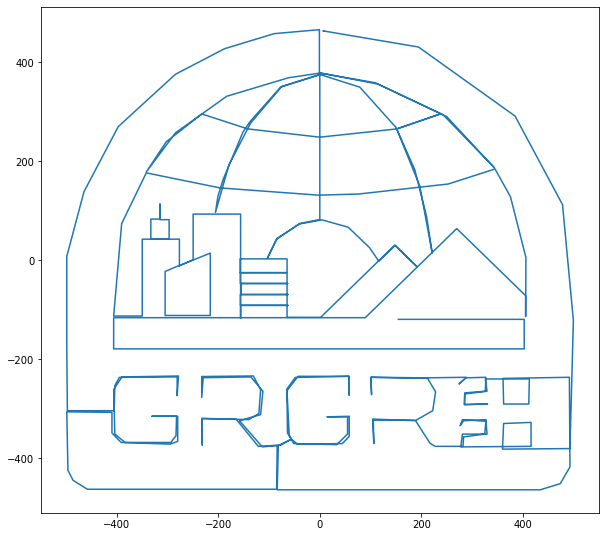

In [4]:
plt.figure(figsize=(offset_x/5, offset_y/5))
plt.plot(*zip(*grgr_xy))
plt.show()

### Translate to GPS coordinates

Now we have the vertices in a useable form, we can convert them to latitude and longitude points using the following functions: `bearing_rad`, `getlonlat` which as the names suggest, gets a bearing and gets the longitude and latitude (using the great arc method - check this <a href="https://www.movable-type.co.uk/scripts/latlong.html#dest-point">link</a> out for more details) respectively.

In [5]:
def bearing_rad(x, y):
    
    # Use imaginary numbers to get the bearing to the point:
    z = x + y*1j
    res = math.pi / 2.0 - cm.phase(z)
    
    # Return the resulting angle:
    return res % (2.0 * math.pi)

def getlonlat(lonlat1, xy1, xy2):
    
    # Radius of the Earth in meters:
    R = 6371000
    
    # Start point:
    lon1 = math.radians(lonlat1[0])
    lat1 = math.radians(lonlat1[1])
    
    # Vertices of each point used to get the bearing:
    x1 = xy1[0]
    y1 = xy1[1]
    
    x2 = xy2[0]
    y2 = xy2[1]
    
    # Get the bearing between the points:
    bearing = bearing_rad((x2-x1), (y2-y1))
    
    # Get the distance between the points:
    distance = math.sqrt(((x2-x1)**2 + (y2-y1)**2))
    
    # Calculate the latitude and longitude of the end point:
    #φ2 = asin( sin φ1 ⋅ cos δ + cos φ1 ⋅ sin δ ⋅ cos θ )
    #λ2 = λ1 + atan2( sin θ ⋅ sin δ ⋅ cos φ1, cos δ − sin φ1 ⋅ sin φ2 )
    
    lat2 = math.asin(math.sin(lat1)*math.cos(distance/R) + math.cos(lat1)*math.sin(distance/R)*math.cos(bearing))
    
    lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance/R)*math.cos(lat1),
                             math.cos(distance/R) - math.sin(lat1)*math.sin(lat2))
    
    # Convert to the format needed for future use:
    lonlat2 = (math.degrees(lon2), math.degrees(lat2))
    
    # Return point 2's longitude and latitude:
    return lonlat2

Now we just use those new functions on the list of x, y coordinates (using the starting centre point we defined earlier to prime the first latitude and longitude):

In [6]:
# Create empty array to collect longitudes and latitudes:
grgr_lonlat = []

# Append the first point into the array:
grgr_lonlat.append(getlonlat((centre_latlon[1], centre_latlon[0]), (0,0), grgr_xy[0]))

# Cycle through the remaining points:
for i in range(len(grgr_xy)-1):
    grgr_lonlat.append(getlonlat(grgr_lonlat[i], grgr_xy[i], grgr_xy[i+1]))


With this we can now form our geodataframe with a linestring (which is the needed format for creating a GPX route file):

In [7]:
# Create a linestring from the longitude and latitude gathered above:
grgr_line = LineString(grgr_lonlat)

# Create a pandas dataframe:
data = {'geometry': [grgr_line]}
grgr_line_df = pd.DataFrame(data, columns = ['id', 'geometry'])

# Create the GeoDataFrame from the above:
grgr_route = GeoDataFrame(grgr_line_df, crs="epsg:4326")

### Visualise in GPS coordinate view

Lastly we can plot it on a map to see how it fits in the surrounding area (this is where having a large open space as your canvas is very useful!):

In [8]:
figg = folium.Figure(height = 500)
mapp = folium.Map(centre_latlon, zoom_start = 15, tiles='OpenStreetMap')
mapp.add_to(figg)

folium.GeoJson(grgr_route).add_to(mapp)
mapp

### Output the GPS route file

Finally, the last task is to just output to GPX file (to the file location set at the beginning):

In [9]:
grgr_route.to_file(grgr_gpx, driver="GPX", FORCE_GPX_ROUTE="YES", GPX_USE_EXTENSIONS="YES")

This should then have created a file in the `out` folder where this Jupyter Notebook is running.

If you need a hand finding this then:

<ul>
    <li>
        Go to the home page which should look like this
        <img src="./how-to/play-home.PNG" alt="Home page" width="700"/>
    </li>
    <li>
        Click on the <code>out</code> folder and then click on the <code>.gpx</code> file that should be in there.
    </li>
    <li>
        Then at the top of the page there should be a drop down menu for file with a download option, click this and save it.
        <img src="./how-to/play-download.PNG" alt="Download route" width="700"/>
    </li>
    <li>
        You can now use this a navigation tool for your next bit of GPS art. I use it on my watch as a route to navigate and on my phone using a GPX viewer app.
    </li>
</ul>
   

# Further analysis

Further analysis can be done with the data we have created. One thing that I found is useful look at is the route's route (if that makes sense!). With this we can also extract the distance between points to gauge the routes length.

Firstly, we have to split up the routes single LineString into each leg of the route. This is done using the following function to pull out the information:

In [10]:
def make_lines(gdf, df_out, i, geometry = 'geometry'):
    
    # Get the adjacent points:
    geom0 = gdf[i]
    geom1 = gdf[i + 1]
    
    # Organise them in a way that is easy to use and produce a linestring:
    start, end = [(geom0[0], geom0[1]), (geom1[0], geom1[1])]
    line = LineString([start, end])
    
    # Create a DataFrame to hold the record:
    data = {'id': i,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
    # Add the record DataFrame of compiled records (given as an input to the function):
    df_out = pd.concat([df_out, df_line])
    
    # Return the updated DataFrame:
    return df_out

Now we just make use of the function and split out the lines

In [11]:
# initialize an output DataFrame
df = pd.DataFrame(columns = ['id', 'geometry'])

# Loop through each row of the input point GeoDataFrame
x = 0
while x < len(grgr_lonlat) - 1:
    df = make_lines(grgr_lonlat, df, x)
    x = x + 1

df.set_index('id', inplace=True)

In [12]:
grgr_line = GeoDataFrame(df, crs="epsg:4326")

ECKERT_IV_PROJ4_STRING = "+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

grgr_line = grgr_line.to_crs(ECKERT_IV_PROJ4_STRING)

grgr_line['dist'] = grgr_line.length

grgr_line['sum'] = 0

for i in range(len(grgr_line)-1):
    grgr_line.loc[i+1, 'sum'] = grgr_line.loc[i, 'sum'] + grgr_line.loc[i+1, 'dist'] / 1000

grgr_line = grgr_line.to_crs("epsg:4326")

And finally we can plot it using a colourful colour map based on the distance (notice the scale in the top right for a gauge of distance):

In [13]:
import branca.colormap as bcm
import math

f2 = folium.Figure(height = 500)
m2 = folium.Map(centre_latlon, zoom_start = 15, tiles='OpenStreetMap')

total_distance = grgr_line['sum'].max()
linear = bcm.linear.Set1_08.scale(0,total_distance)
gps_lyr = folium.GeoJson(grgr_line,
                         style_function = lambda feature: {
                             'color': linear(feature['properties']['sum']),
                             'weight': 5})       


gps_lyr.add_child
    
m2.add_child(linear)
m2.add_child(gps_lyr)
m2.add_to(f2)

# Time for you to play

Now you have seen the code at work, you can play with it! Here are some things to try.

## Basic

In the code box that has <code>########### FOR YOU TO PLAY WITH ################</code> at the top try changing:
<ul>    
    <li>
        the scale by editing the line <code>scale = 10</code> to <code>scale = 20</code>
    </li>
    <li>
        the centre location to near you by changing <code>centre_latlon = [50.9615, -1.6034]</code> to <code>centre_latlon = [ your_lat , your_lon ]</code> where <code> your_lat , your lon </code> are your coordinates
    </li>
    <li> the image to a donkey by changing <code>grgr_dxf = dxfgrabber.readfile("./img/grgr2020.dxf")</code> to <code>grgr_dxf = dxfgrabber.readfile("./img/donkey.dxf")</code>
    </li>
</ul>

## Advanced

<ul> 
    <li>
        Try designing your own image by creating a DXF file as discussed at the top of the page. You can also check out my <code>grgr2020.svg</code> and <code>grgr2020.dfx</code> files in the <code>img</code> folder to set the details.
    </li>
    <li>
        Then upload it by going to the <code>img</code> folder form the home screen and clicking upload.
        <img src="./how-to/play-diy.PNG" alt="Upload your own" width="700"/>
    </li>
    <li>
        Then follow the instructions in Basic for changing the image file name (you might also want to change the output name too).



# Notes and useful resources

Remember this it not a polished document and still can be improved. If you have any suggestion feel free to get in touch.

Below are useful links that helped me throughout writing this:
<ul>
    <li> <a href"http://ryan-m-cooper.com/blog/gps-points-to-line-segments.html">http://ryan-m-cooper.com/blog/gps-points-to-line-segments.html</a> </li>
    <li> <a href"https://www.movable-type.co.uk/scripts/latlong.html#dest-point">https://www.movable-type.co.uk/scripts/latlong.html#dest-point</a> </li>
</ul>
    